<a href="https://colab.research.google.com/github/soumya-mishra/Python-ML/blob/master/Tensorflow/Tensorflow_serve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* This guide trains a neural network model to classify images of clothing, like sneakers and shirts,
* saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/serving/). 
* This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb),a high-level API to build and train models in TensorFlow.

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.15.0


## Create model

### Import the Fashion MNIST dataset

* This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. * The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

* Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. 
* You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

* Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [0]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 164us/sample - loss: 0.5435 - acc: 0.8119
Epoch 2/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3993 - acc: 0.8611
Epoch 3/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.3680 - acc: 0.8719
Epoch 4/5
60000/60000 [==============================]

## Save your model

* We first need to save the model in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format. 
*This will create a protobuf file in a well-defined directory hierarchy, and will include a version number. 
* [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  
* Each version will be exported to a different sub-directory under the given path.

In [0]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.simple_save(
    keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 72
-rw-r--r-- 1 root root 66287 Jan  4 11:28 saved_model.pb
drwxr-xr-x 2 root root  4096 Jan  4 11:28 variables


In [0]:
keras.backend.get_session()


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.

In [0]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax/Softmax:0
  Method name is: tensorflow/serving/predict


* In this case we just trained our model, so we already know the inputs and outputs.

## Serve your model with TensorFlow Serving

### Add TensorFlow Serving distribution URI as a package source:

* TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment. 
* `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

* Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [0]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  15654      0 --:--:-- --:--:-- --:--:-- 15571
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubunt

### Install TensorFlow Serving

* This is all you need - one command line!

In [0]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 140 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.0.0 [140 MB]
Fetched 140 MB in 2s (75.8 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.0.0_all.deb ...
Unpacking tensorflow-model-server (2.0.0) ...
Setting up tensorflow-model-server (2.0.0) ...


### Start running TensorFlow Serving

* start running TensorFlow Serving and load our model.
* After it loads we can start making inference requests using REST.
* There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [0]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [0]:
!tail server.log

2020-01-04 11:31:44.633170: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2020-01-04 11:31:44.634063: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-04 11:31:44.643740: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2020-01-04 11:31:44.653175: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 21098 microseconds.
2020-01-04 11:31:44.653526: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2020-01-04 11:31:44.653598: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2020-01-04 11:31:44.654476: I tensorflow_serving/mode

## Make a request to your model in TensorFlow Serving

* let's take a look at a random example from our test data.

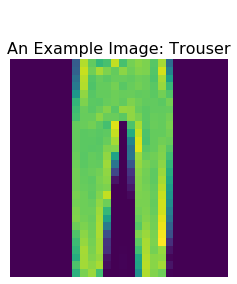

In [0]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

* Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [0]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


Make REST requests

#### Newest version of the servable

* send a predict request as a POST to our server's REST endpoint,
* and pass it three examples.
* We'll ask our server to give us the latest version of our servable 
  by not specifying a particular version.

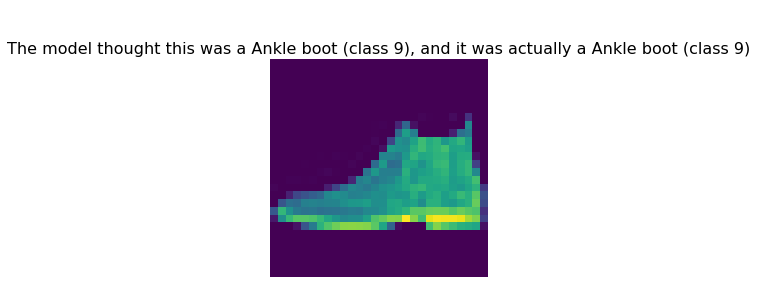

In [0]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[np.argmax(predictions[0])], test_labels[0]))

#### A particular version of the servable

* Now let's specify a particular version of our servable.
* Since we only have one, let's select version 1.
* We'll also look at all three results.

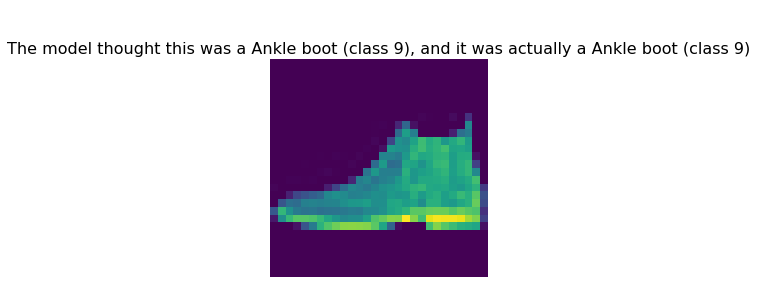

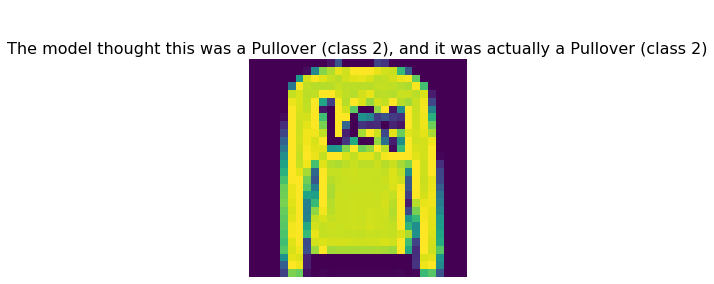

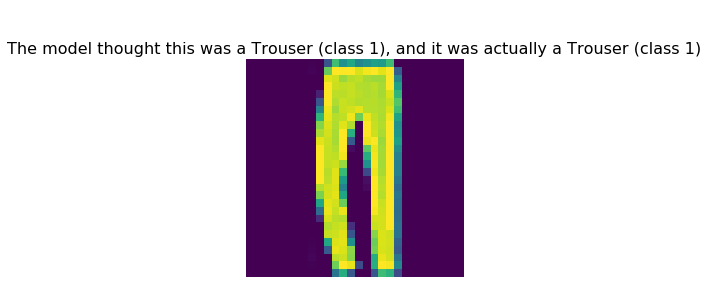

In [0]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], test_labels[i], class_names[np.argmax(predictions[i])], test_labels[i]))